<a href="https://colab.research.google.com/github/sharma-himanshukumar/LLM_Learning/blob/main/Image_embedding_%26_vector_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install kdbai_client matplotlib umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00


In [ ]:

import requests
import os
from PIL import Image
import io

!mkdir -p ./data/meningioma_tumor
!mkdir -p ./data/glioma_tumor
!mkdir -p ./data/no_tumor
!mkdir -p ./data/pituitary_tumor


def get_github_repo_contents(repo_owner, repo_name, branch, folder_path):
    # Construct the API URL
    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch}"

    # Send the request and process the response
    contents = requests.get(api_url).json()

    # Create the local directory if it doesn't exist
    fPath = f"./data/{folder_path.split('/')[-1]}"

    for item in contents:
        # Recursively list contents of subfolder
        if item['type'] == 'dir':
            get_github_repo_contents(repo_owner, repo_name, branch, f"{folder_path}/{item['name']}")
        # Download and save file
        elif item['type'] == 'file':
            file_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}{folder_path}/{item['name']}"
            # print(file_url)
            r = requests.get(file_url, timeout=4.0)
            r.raise_for_status()  # Raises an exception for HTTP errors
            with Image.open(io.BytesIO(r.content)) as im:
                im.save(f"{fPath}/{item['name']}")

# Get data
get_github_repo_contents(
    repo_owner='KxSystems',
    repo_name='kdbai-samples',
    branch='main',
    folder_path='/image_search/data'
)

import os
### ignore tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# force tensorflow to use CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""


# download data
from zipfile import ZipFile
# embeddings
from tensorflow.keras.utils import image_dataset_from_directory
from huggingface_hub import from_pretrained_keras
from PIL import Image
import numpy as np
import pandas as pd
# timing
from tqdm.auto import tqdm
# vector DB
import kdbai_client as kdbai
from getpass import getpass
import time
# plotting
import umap.umap_ as umap
from matplotlib import pyplot as plt

def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()
def plot_image(axis, source: str, label=None) -> None:
    axis.imshow(plt.imread(source))
    axis.axis("off")
    title = (f"{label}: " if label else "") + source.split("/")[-1]
    axis.set_title(title)

def extract_file_paths_from_folder(parent_dir: str) -> dict:
    image_paths = {}
    for sub_folder in os.listdir(parent_dir):
        sub_dir = os.path.join(parent_dir, sub_folder)
        image_paths[sub_folder] = [
            os.path.join(sub_dir, file) for file in os.listdir(sub_dir)
        ]
    return image_paths
image_paths_map = extract_file_paths_from_folder("data")

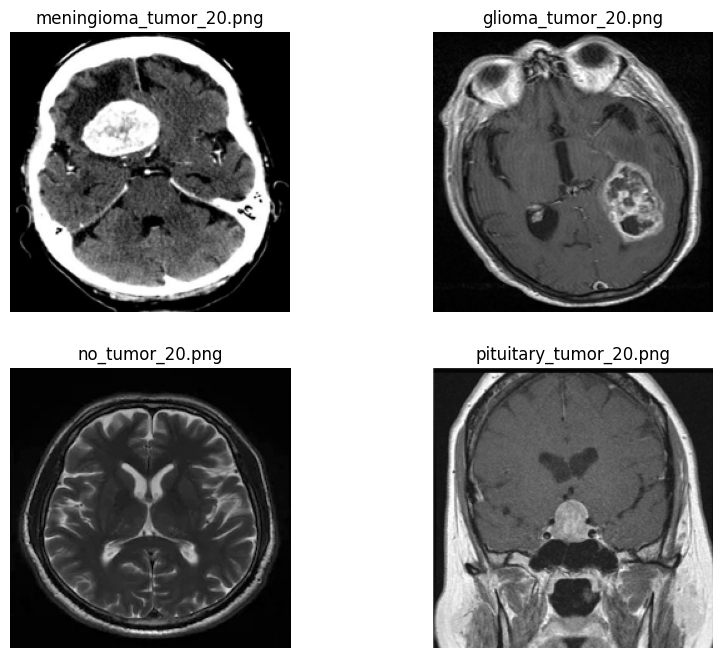

In [ ]:
image_index = 20  # feel free to change this!
# create subplots
_, ax = plt.subplots(nrows=len(image_paths_map) // 2, ncols=2, figsize=(10, 8))
axes = ax.reshape(-1)

# get image at specified index
for i, (_, image_paths) in enumerate(image_paths_map.items()):
    for path in image_paths:
        if path.endswith(f"{image_index}.png"):
            break

    # plot each image in subplots
    plot_image(axes[i], path)

In [ ]:
dataset = image_dataset_from_directory(
    "data",
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    seed=1,
    image_size=(224, 224),
    batch_size=1,
)

model = from_pretrained_keras("KxSystems/mri_resnet_model")
model.pop()
model.pop()

# create empty arrays to store the embeddings and labels
embeddings = np.empty([len(dataset), 2048])
labels = np.empty([len(dataset), 4])
# for each image in dataset, get its embedding and class label
for i, image in tqdm(enumerate(dataset), total=len(dataset)):
    embeddings[i, :] = model.predict(image[0], verbose=0)
    labels[i, :] = image[1]

# list the tumor types in sorted order
tumor_types = sorted(image_paths_map.keys())
# for each vector, save the tumor type given by the high index
class_labels = [tumor_types[label.argmax()] for label in labels]

# get a single list of all paths
all_paths = []
for _, image_paths in image_paths_map.items():
    all_paths += image_paths
# sort the source_files in alphanumeric order
sorted_all_paths = sorted(all_paths)


embedded_df = pd.DataFrame(
    {
        "source": sorted_all_paths,
        "class": class_labels,
        "embedding": embeddings.tolist(),
    }
)

_umap = umap.UMAP(n_neighbors=15, min_dist=0.0)
umap_df = pd.DataFrame(_umap.fit_transform(embeddings), columns=["u0", "u1"])


Found 394 files belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/43.7k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/572k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/283M [00:00<?, ?B/s]

  0%|          | 0/394 [00:00<?, ?it/s]

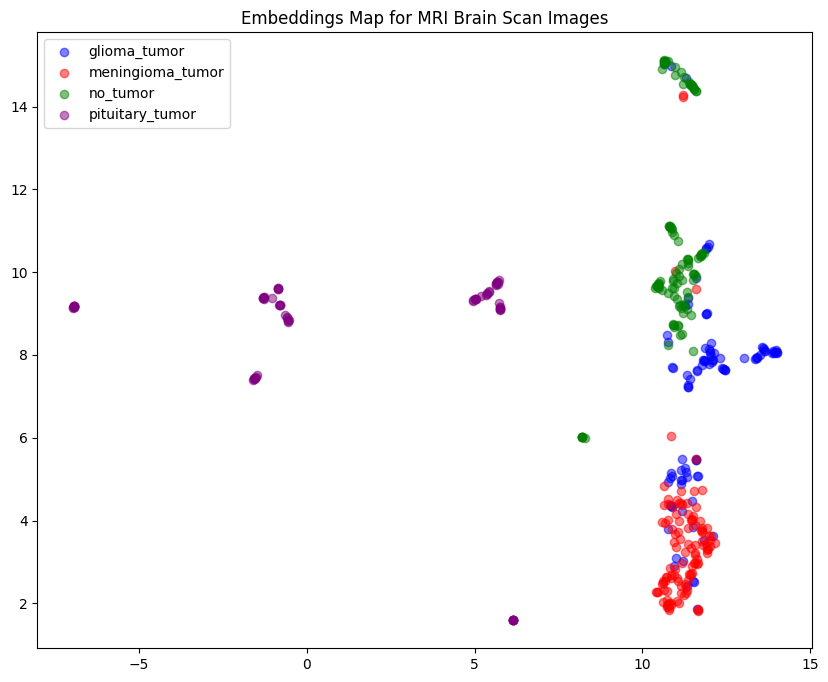

In [ ]:
# define color for each class label
class_colors = ["blue", "red", "green", "purple"]
# Create a figure for plotting
plt.figure(figsize=(10, 8))

# Scatter plot with 'u0' and 'u1' columns as x and y, color mapped by class_labels
for tumor_type, color in zip(tumor_types, class_colors):
    indices_to_plot = [i for i, label in enumerate(class_labels) if label == tumor_type]
    subset = umap_df.iloc[indices_to_plot]
    plt.scatter(subset["u0"], subset["u1"], label=tumor_type, color=color, alpha=0.5)

# beutify plot
plt.title("Embeddings Map for MRI Brain Scan Images")
plt.legend()
plt.show()

In [ ]:
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)

KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

KDB.AI endpoint: https://cloud.kdb.ai/instance/99ts7ewvt7
KDB.AI API key: ··········


In [ ]:
image_schema = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims": 2048, "metric": "L2", "type": "hnsw"},
        },
    ]
}

# ensure the table does not already exist
try:
    session.table("mri").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass
table = session.create_table("mri", image_schema)

embedded_df.memory_usage(deep=True).sum() / (1024**2)

table.insert(embedded_df)

table.query()
table.query(filter=[("like", "class", "*glioma_tumor*")])
random_row_index_1 = 40
random_row_1 = embedded_df.iloc[random_row_index_1]
plot_image(plt.subplots()[-1], random_row_1["source"], label="Query Image")

In [ ]:
sample_embedding_1 = random_row_1["embedding"]
results_1 = table.search([sample_embedding_1], n=9)
results_1[0]

,source,class,embedding,__nn_distance
0,data/glioma_tumor/glioma_tumor_45.png,glioma_tumor,"[0.6581199169158936, 0.7380955219268799, 0.374...",0.000000
1,data/glioma_tumor/glioma_tumor_71.png,glioma_tumor,"[0.5400809645652771, 0.6335983872413635, 0.327...",655.003174
2,data/glioma_tumor/glioma_tumor_61.png,glioma_tumor,"[1.1261733770370483, 1.0511531829833984, 0.607...",695.868652
3,data/glioma_tumor/glioma_tumor_95.png,glioma_tumor,"[0.6331982016563416, 0.5156578421592712, 0.037...",709.470642
4,data/glioma_tumor/glioma_tumor_47.png,glioma_tumor,"[0.7627273797988892, 1.3249704837799072, 0.009...",711.554810
5,data/glioma_tumor/glioma_tumor_68.png,glioma_tumor,"[0.5686506032943726, 1.2953143119812012, 0.092...",714.166321
6,data/glioma_tumor/glioma_tumor_41.png,glioma_tumor,"[0.14557020366191864, 0.7579463124275208, 1.33...",716.417358
7,data/glioma_tumor/glioma_tumor_46.png,glioma_tumor,"[1.7890287637710571, 0.47240081429481506, 0.27...",734.459473
8,data/glioma_tumor/glioma_tumor_12.png,glioma_tumor,"[0.21819375455379486, 0.19898559153079987, 0.0...",751.183472


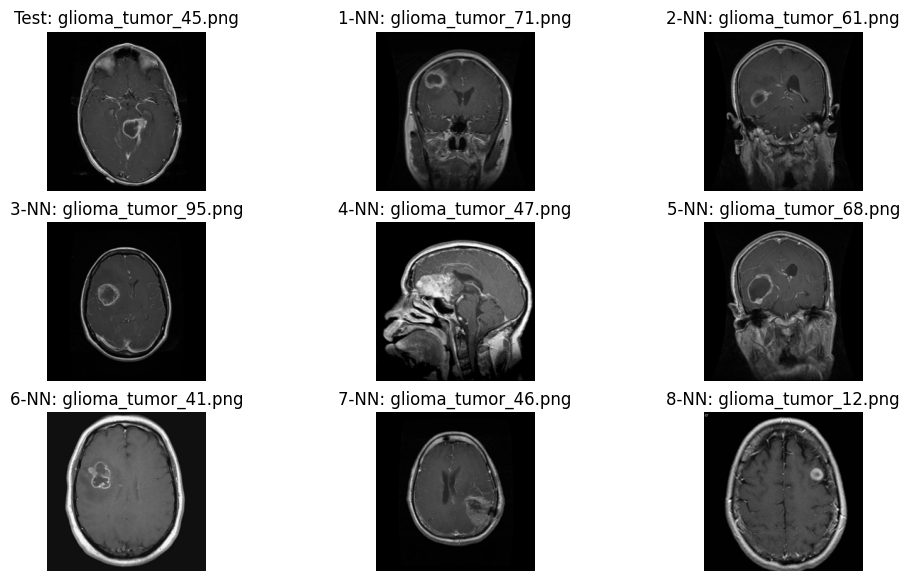

In [ ]:
def plot_test_result_with_8NN(test_file: str, neighbors: pd.Series) -> None:
    # create figure
    _, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
    axes = ax.reshape(-1)

    # plot query image
    plot_image(axes[0], test_file, "Test")

    # plot nearest neighbors
    for i, (_, value) in enumerate(neighbors.items(), start=1):
        plot_image(axes[i], value, f"{i}-NN")
nn1_filenames = results_1[0][1:]["source"]
plot_test_result_with_8NN(random_row_1["source"], nn1_filenames)

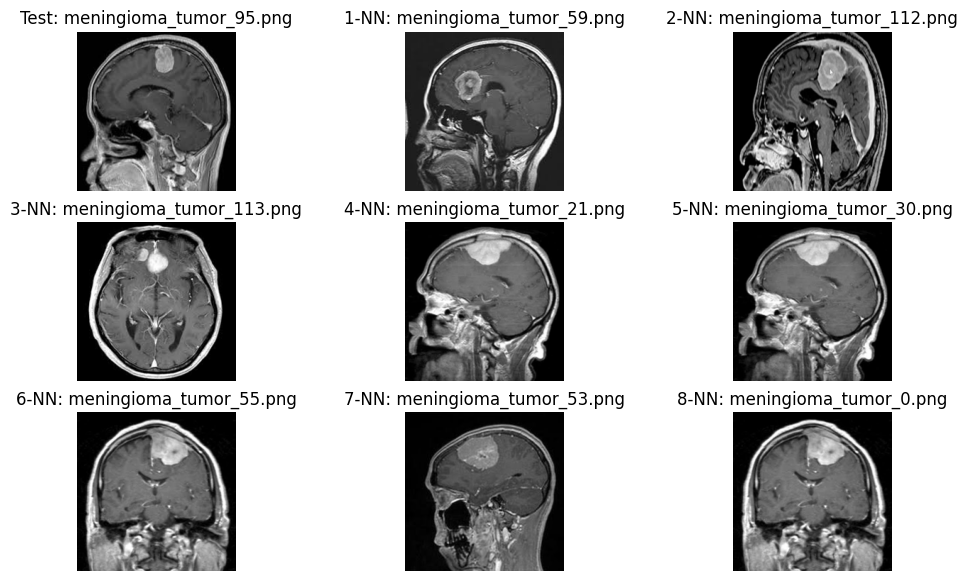

In [ ]:
def mri_image_nn_search(table, df: pd.DataFrame, row_index: int) -> None:
    # Select the random row and the desired column's value
    row = df.iloc[row_index]

    # get the embedding from this row
    row_embedding = row["embedding"]

    # search for 8 nearest neighbors (exclude self)
    nn_results = table.search([row_embedding], n=9)[0][1:]

    # plot the neighbors
    plot_test_result_with_8NN(row["source"], nn_results["source"])

# Get another row
random_row_index_2 = 210
mri_image_nn_search(table, embedded_df, random_row_index_2)

In [ ]:
table.drop()

True